<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/main/notebooks/simple-train-small-case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/main/notebooks/simple-train-small-case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Object Detection - Small Case Training
A minimal implementation for learning object detection with bounding boxes using 1-20 training samples

## Setup and Imports

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Download dataset

In [2]:
!pip install -q kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


#### Session storage

In [ ]:
!kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining

import zipfile
import os

zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

#### Google Drive (recommended)

In [4]:
!kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining

import zipfile
import os
from google.colab import drive


drive.mount('/content/drive')

zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"
extract_path = "/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

penyisihan-hology-8-0-2025-data-mining.zip: Skipping, found more recently modified local copy (use --force to force download)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to: /content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset


In [5]:
BASE_DRIVE_DIR = '/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025'

## Simple Dataset Class for Small Training Set

In [6]:
class SmallObjectDetectionDataset(Dataset):
    def __init__(self, image_dir, label_dir, max_samples=20, img_size=224):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size

        # Get only first max_samples images for small case training
        all_images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.image_files = all_images[:max_samples]

        print(f"Using {len(self.image_files)} images for training")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load and resize image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0

        # Load labels (YOLO format)
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        # class_id, x_center, y_center, width, height (normalized)
                        boxes.append([float(x) for x in parts[1:]])  # Skip class_id for simplicity

        # If no boxes, add dummy box
        if len(boxes) == 0:
            boxes = [[0.5, 0.5, 0.1, 0.1]]  # center dummy box

        # Convert to tensor
        image_tensor = torch.FloatTensor(image).permute(2, 0, 1)
        boxes_tensor = torch.FloatTensor(boxes)

        # For simplicity, just return first box (single object detection)
        if len(boxes) > 0:
            target_box = boxes_tensor[0]  # [x_center, y_center, width, height]
        else:
            target_box = torch.FloatTensor([0.5, 0.5, 0.1, 0.1])

        # Add object confidence (1 if object exists, 0 if dummy)
        has_object = 1.0 if len(boxes) > 0 and not (boxes[0] == [0.5, 0.5, 0.1, 0.1]) else 0.0
        target = torch.cat([torch.tensor([has_object]), target_box])  # [conf, x, y, w, h]

        return image_tensor, target

## Simple CNN Model for Object Detection

In [7]:
class SimpleDetector(nn.Module):
    def __init__(self):
        super(SimpleDetector, self).__init__()

        # Simple CNN backbone
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112

            # Second block
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112 -> 56

            # Third block
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56 -> 28

            # Fourth block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28 -> 14
        )

        # Detection head - outputs 5 values: [confidence, x, y, w, h]
        self.detector = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 5)  # [confidence, x_center, y_center, width, height]
        )

    def forward(self, x):
        features = self.features(x)
        detection = self.detector(features)

        # Apply activations
        confidence = torch.sigmoid(detection[:, 0:1])  # confidence between 0-1
        bbox = torch.sigmoid(detection[:, 1:])          # bbox coordinates between 0-1

        return torch.cat([confidence, bbox], dim=1)

# Initialize model
model = SimpleDetector().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Model architecture:")
print(model)

Model parameters: 106,021
Model architecture:
SimpleDetector(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (detector): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Dropo

## Load Small Dataset

In [8]:
# Load small training dataset (adjust paths as needed)
train_dataset = SmallObjectDetectionDataset(
    image_dir=f'{BASE_DRIVE_DIR}/dataset/train/images',
    label_dir=f'{BASE_DRIVE_DIR}/dataset/train/labels',
    max_samples=20,  # Use only 20 samples for small case
    img_size=224
)

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

print(f"Training with {len(train_dataset)} samples")
print(f"Number of batches: {len(train_loader)}")

Using 20 images for training
Training with 20 samples
Number of batches: 5


## Simple Loss Function

In [9]:
def simple_detection_loss(predictions, targets, lambda_coord=5.0):
    """
    Simple loss function for object detection
    predictions: [batch_size, 5] - [conf, x, y, w, h]
    targets: [batch_size, 5] - [conf, x, y, w, h]
    """
    # Confidence loss (binary cross entropy)
    conf_loss = nn.BCELoss()(predictions[:, 0], targets[:, 0])

    # Coordinate loss (only for samples with objects)
    has_object = targets[:, 0] > 0.5
    if has_object.sum() > 0:
        coord_loss = nn.MSELoss()(
            predictions[has_object, 1:],
            targets[has_object, 1:]
        )
    else:
        coord_loss = torch.tensor(0.0, device=device)

    total_loss = conf_loss + lambda_coord * coord_loss

    return total_loss, conf_loss, coord_loss

## Training Loop

Starting training...
Epoch 1/50:
  Total Loss: 0.6334
  Conf Loss: 0.6334
  Coord Loss: 0.0000

Epoch 10/50:
  Total Loss: 0.0000
  Conf Loss: 0.0000
  Coord Loss: 0.0000

Epoch 20/50:
  Total Loss: 0.0000
  Conf Loss: 0.0000
  Coord Loss: 0.0000

Epoch 30/50:
  Total Loss: 0.0000
  Conf Loss: 0.0000
  Coord Loss: 0.0000

Epoch 40/50:
  Total Loss: 0.0000
  Conf Loss: 0.0000
  Coord Loss: 0.0000

Epoch 50/50:
  Total Loss: 0.0000
  Conf Loss: 0.0000
  Coord Loss: 0.0000

Training completed!


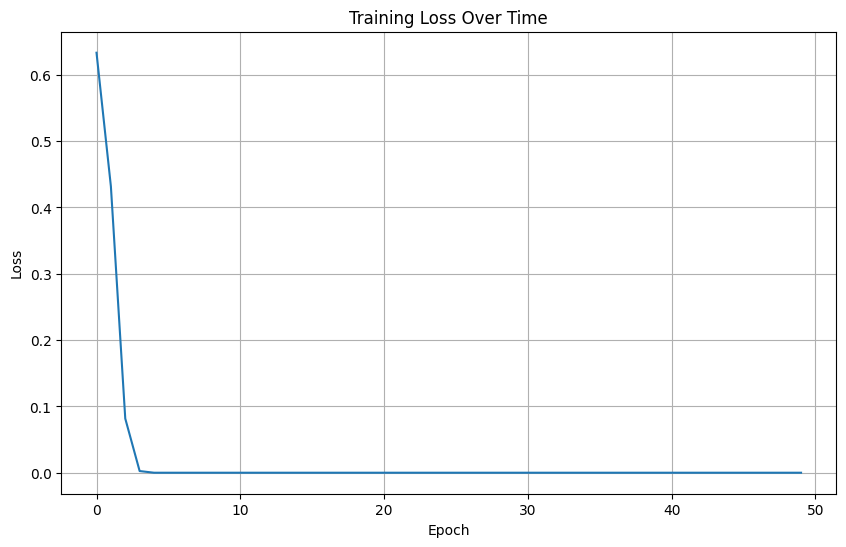

In [10]:
# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50  # More epochs for small dataset

# Training loop
model.train()
training_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_conf_loss = 0.0
    epoch_coord_loss = 0.0
    num_batches = 0

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(images)

        # Calculate loss
        total_loss, conf_loss, coord_loss = simple_detection_loss(predictions, targets)

        # Backward pass
        total_loss.backward()
        optimizer.step()

        # Accumulate losses
        epoch_loss += total_loss.item()
        epoch_conf_loss += conf_loss.item()
        epoch_coord_loss += coord_loss.item()
        num_batches += 1

    # Calculate average losses
    avg_loss = epoch_loss / num_batches
    avg_conf_loss = epoch_conf_loss / num_batches
    avg_coord_loss = epoch_coord_loss / num_batches

    training_losses.append(avg_loss)

    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Total Loss: {avg_loss:.4f}')
        print(f'  Conf Loss: {avg_conf_loss:.4f}')
        print(f'  Coord Loss: {avg_coord_loss:.4f}')
        print()

print("Training completed!")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(training_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Prediction and Visualization

In [11]:
def predict_single_image(model, image_path, conf_threshold=0.5):
    """
    Predict object in a single image
    """
    model.eval()

    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]

    # Resize and normalize
    resized_image = cv2.resize(image, (224, 224))
    input_tensor = torch.FloatTensor(resized_image).permute(2, 0, 1).unsqueeze(0) / 255.0
    input_tensor = input_tensor.to(device)

    # Predict
    with torch.no_grad():
        prediction = model(input_tensor)

    # Extract prediction values
    confidence = prediction[0, 0].item()
    x_center = prediction[0, 1].item()
    y_center = prediction[0, 2].item()
    width = prediction[0, 3].item()
    height = prediction[0, 4].item()

    # Convert to absolute coordinates
    x_center_abs = x_center * orig_w
    y_center_abs = y_center * orig_h
    width_abs = width * orig_w
    height_abs = height * orig_h

    # Calculate bounding box corners
    x1 = int(x_center_abs - width_abs/2)
    y1 = int(y_center_abs - height_abs/2)
    x2 = int(x_center_abs + width_abs/2)
    y2 = int(y_center_abs + height_abs/2)

    detection = {
        'confidence': confidence,
        'bbox': [x1, y1, x2, y2],
        'has_object': confidence > conf_threshold
    }

    return image, detection

def visualize_detection(image, detection, title="Object Detection Result"):
    """
    Visualize detection result
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(image)

    if detection['has_object']:
        x1, y1, x2, y2 = detection['bbox']
        confidence = detection['confidence']

        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                           fill=False, color='red', linewidth=3)
        plt.gca().add_patch(rect)

        # Add confidence text
        plt.text(x1, y1-10, f'Person: {confidence:.3f}',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.8),
                fontsize=12, color='white', weight='bold')

        count_text = "1 person detected"
    else:
        count_text = "No person detected"

    plt.title(f'{title}\n{count_text}', fontsize=14, weight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return count_text

## Test the Model

Testing model on training images:

Testing image 1: 418.jpg
Confidence: 0.000
Has object: False


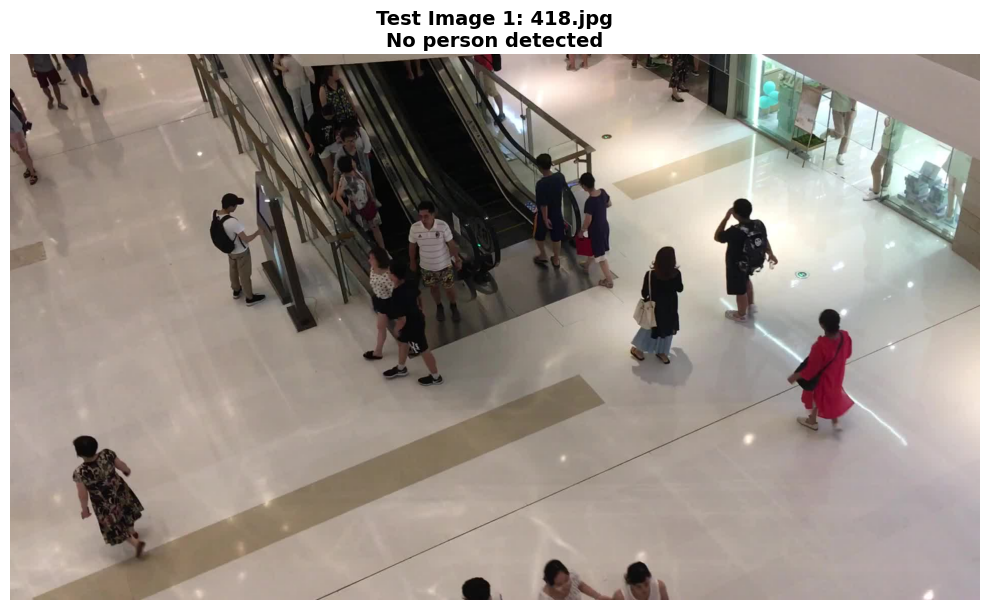

Result: No person detected
------------------------------

Testing image 2: 419.jpg
Confidence: 0.000
Has object: False


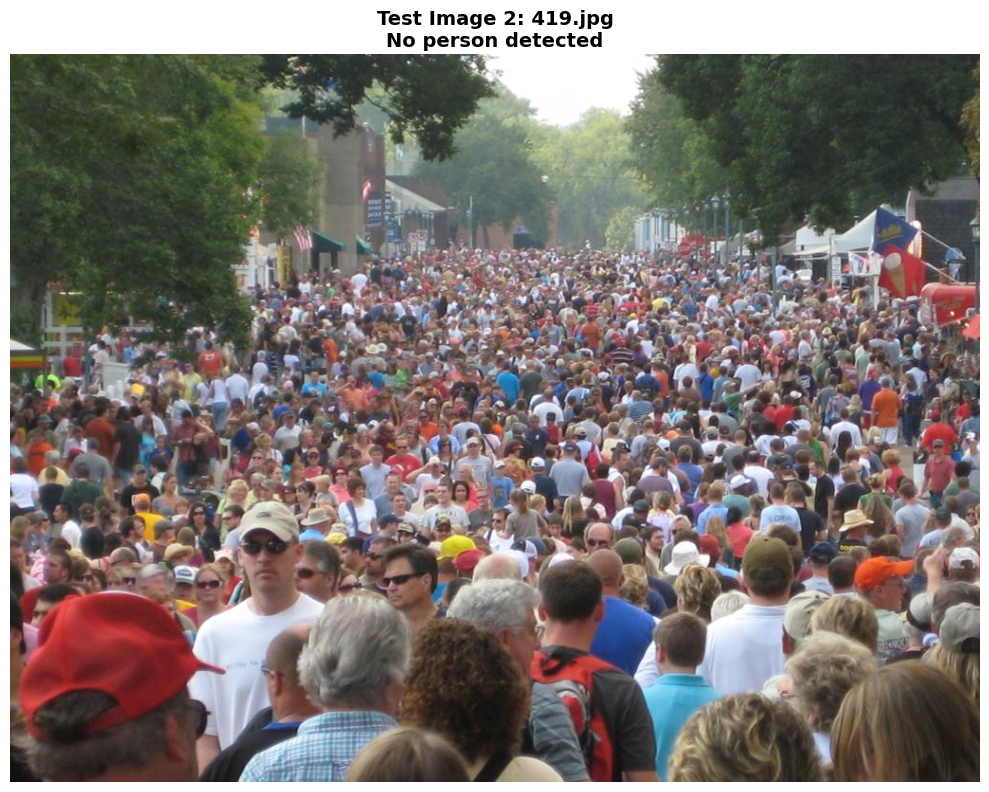

Result: No person detected
------------------------------

Testing image 3: 42.jpg
Confidence: 0.000
Has object: False


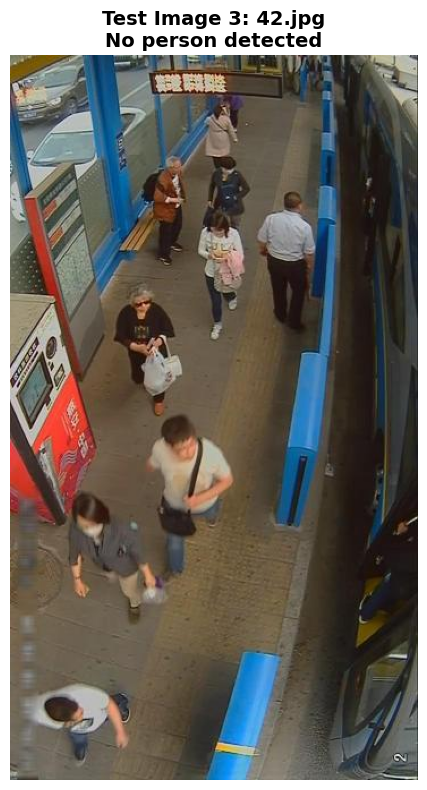

Result: No person detected
------------------------------

Testing image 4: 420.jpg
Confidence: 0.000
Has object: False


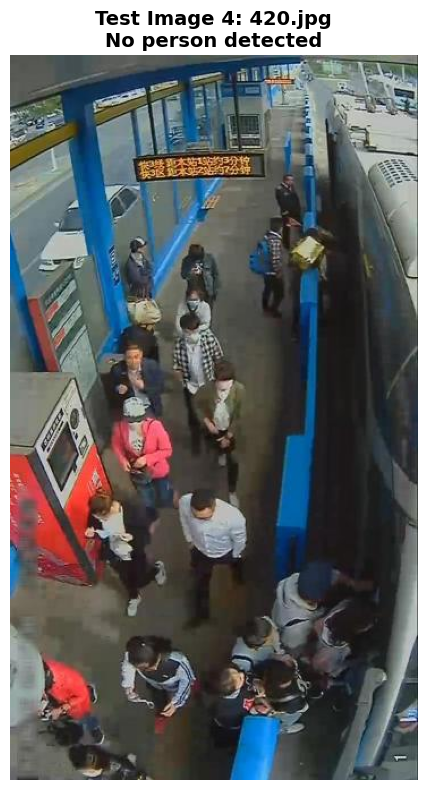

Result: No person detected
------------------------------

Testing image 5: 421.jpg
Confidence: 0.000
Has object: False


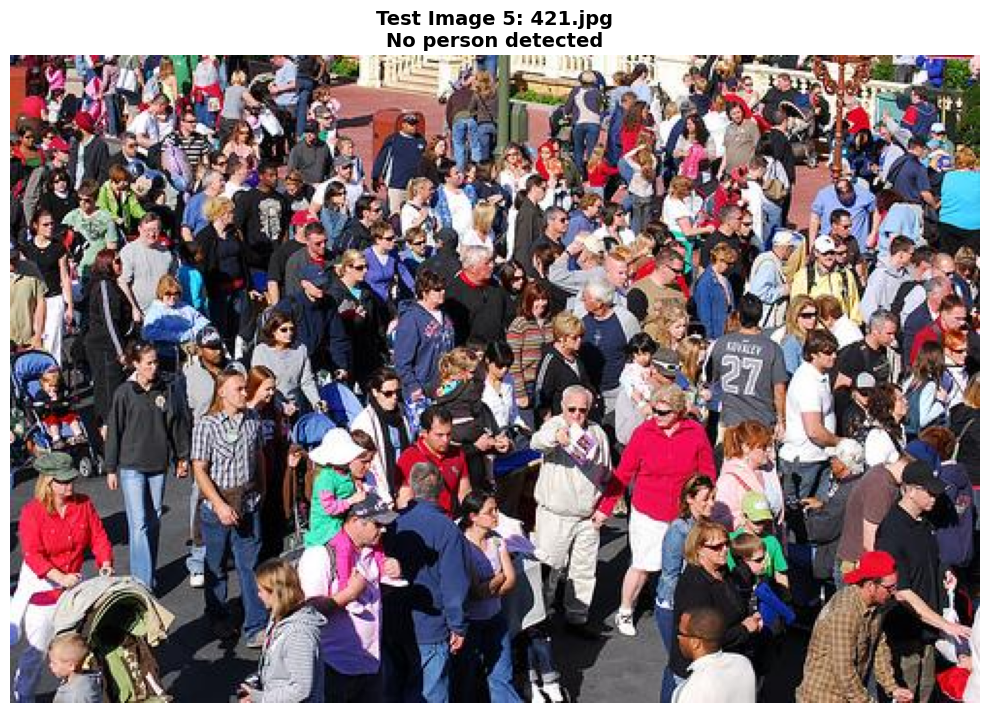

Result: No person detected
------------------------------


In [15]:
# Test on training images to see if model learned
print("Testing model on training images:")
print("=" * 50)

test_image_dir = f'{BASE_DRIVE_DIR}/dataset/test/images'
sample_images = [f for f in os.listdir(test_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Test on first 5 training images
for i, img_name in enumerate(sample_images[:5]):
    img_path = os.path.join(test_image_dir, img_name)
    print(f"\nTesting image {i+1}: {img_name}")

    try:
        image, detection = predict_single_image(model, img_path, conf_threshold=0.3)

        print(f"Confidence: {detection['confidence']:.3f}")
        print(f"Has object: {detection['has_object']}")
        if detection['has_object']:
            print(f"Bounding box: {detection['bbox']}")

        # Visualize
        count_result = visualize_detection(image, detection, f"Test Image {i+1}: {img_name}")
        print(f"Result: {count_result}")

    except Exception as e:
        print(f"Error processing {img_name}: {e}")

    print("-" * 30)

## Model Summary and People Counting Function


People Counting Example:
People count: 0
Confidence: 0.000


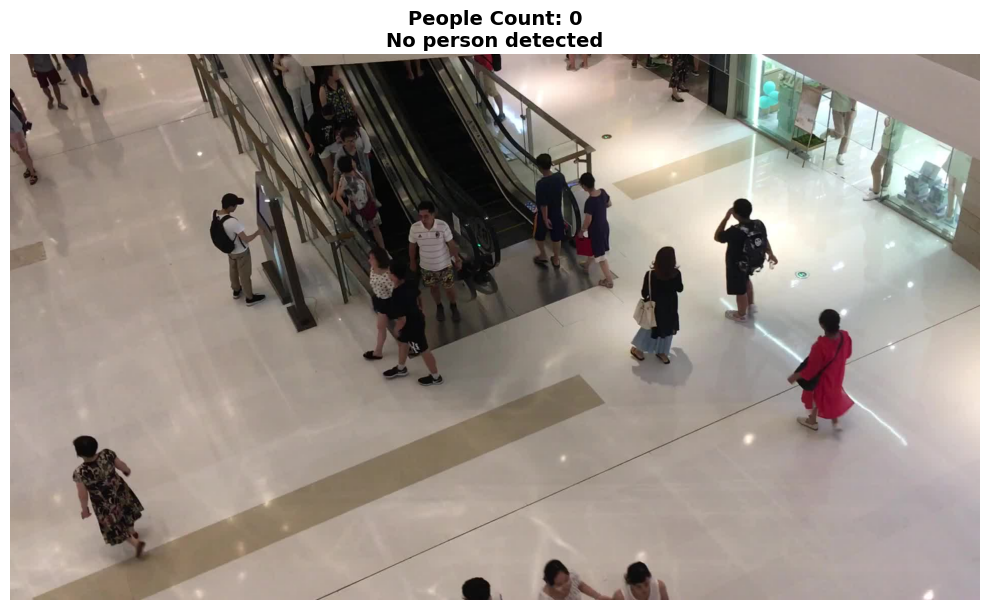


Model Training Complete!
This simple model can detect single objects with 106,021 parameters
For multiple object detection, you would need a more complex architecture like YOLO or R-CNN


In [16]:
def count_people_in_image(model, image_path, conf_threshold=0.5):
    """
    Count people in an image (simplified version - single detection)
    """
    image, detection = predict_single_image(model, image_path, conf_threshold)

    # For this simple model, we can only detect 1 person max
    people_count = 1 if detection['has_object'] else 0

    result = {
        'image': image,
        'people_count': people_count,
        'confidence': detection['confidence'],
        'detection': detection
    }

    return result

# Example usage
print("\nPeople Counting Example:")
print("=" * 30)

if len(sample_images) > 0:
    test_image = os.path.join(test_image_dir, sample_images[0])
    result = count_people_in_image(model, test_image, conf_threshold=0.3)

    print(f"People count: {result['people_count']}")
    print(f"Confidence: {result['confidence']:.3f}")

    visualize_detection(
        result['image'],
        result['detection'],
        f"People Count: {result['people_count']}"
    )

print("\nModel Training Complete!")
print(f"This simple model can detect single objects with {sum(p.numel() for p in model.parameters()):,} parameters")
print("For multiple object detection, you would need a more complex architecture like YOLO or R-CNN")

## Save the Simple Model

In [17]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_loss': training_losses,
    'model_config': {
        'img_size': 224,
        'num_epochs': num_epochs,
        'num_training_samples': len(train_dataset)
    }
}, 'simple_detector_small_case.pth')

print("Model saved as 'simple_detector_small_case.pth'")
print("\nTraining Summary:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Epochs: {num_epochs}")
print(f"- Final loss: {training_losses[-1]:.4f}")
print(f"- Model size: {sum(p.numel() for p in model.parameters()):,} parameters")

Model saved as 'simple_detector_small_case.pth'

Training Summary:
- Training samples: 20
- Epochs: 50
- Final loss: 0.0000
- Model size: 106,021 parameters
